# cycleGANs for STEM images

In this section, we'll train a GAN to noise up a simulated image to look like an experimental image

## Imports

In [1]:
from make_dataset import parse_and_save_dir, load_train_data
from models import unet_generator, discriminator, generator_resnet
import tensorflow as tf
from plotting_tools import *
import pickle
import time
from glob import glob
from IPython.display import clear_output
import scipy.fftpack as sfft

## Loading in Images
First, we load in large simulated image and experimental images, and cut them into 256x256 chunks. We then store the images in folders.

In [2]:
parent_dir = "C:/Users/abidk/Dropbox/Development/programs/stem-learning/"
exp_dir_raw = parent_dir + "data/WSe_ALL/real_212/"
sim_dir_raw = parent_dir + "data/WSe_ALL/sim_abberation/"

exp_dir = parent_dir + "data/WSe_ALL/real_212_256_slices/"
sim_dir = parent_dir + "data/WSe_ALL/sim_abberation_256_slices/"

fine_size, stride = 256, 256
num_channels=1

In [3]:
#parse_and_save_dir(exp_dir_raw, exp_dir, fine_size, stride)
#parse_and_save_dir(sim_dir_raw, sim_dir, fine_size, stride, num_channels=num_channels)

## Construct Generator and Discriminator
Here, we can choose between a unet generator or a resnet generator.

In [4]:
generator_exp = unet_generator(num_channels, 1, "instancenorm")
generator_sim = unet_generator(1, num_channels, "instancenorm")

#generator_exp = generator_resnet(64, num_channels, 1)
#generator_sim = generator_resnet(64, 1, num_channels)

discriminator_sim = discriminator("instancenorm", num_channels)
discriminator_exp = discriminator("instancenorm", 1)

discriminator_sim_fft = discriminator("instancenorm", num_channels)
discriminator_exp_fft = discriminator("instancenorm", 1)

In [5]:
lr0 = 2e-3
generator_exp_optimizer = tf.keras.optimizers.Adam(lr0)
generator_sim_optimizer = tf.keras.optimizers.Adam(lr0)

discriminator_sim_optimizer = tf.keras.optimizers.Adam(lr0)
discriminator_exp_optimizer = tf.keras.optimizers.Adam(lr0)

discriminator_sim_fft_optimizer = tf.keras.optimizers.Adam(lr0)
discriminator_exp_fft_optimizer = tf.keras.optimizers.Adam(lr0)

## Loss Functions and Accuracies

In [6]:
LAMBDA = 10
#loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, fake):
    real_loss = loss_obj( tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    total_disc_loss = (real_loss*len(real) + fake_loss*len(fake))/(len(real + len(fake)))
    return total_disc_loss

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def L1_loss(img_A, img_B):
    return tf.reduce_mean(tf.abs(img_A - img_B))

def L2_loss(img_A, img_B):
    diff = tf.abs(img_A - img_B)
    return tf.reduce_mean(diff*diff)

## Checkpoints

In [7]:
identifier = "20220126_unet_gen_fft_10_reparamed2"
checkpoint_path = parent_dir + "cycle_gan_results/checkpoints/checkpoint_{}".format(identifier)
log_data_fn = "{}/data_{}.p".format(checkpoint_path, identifier)

ckpt = tf.train.Checkpoint(generator_exp=generator_exp,
                           generator_sim=generator_sim,
                           discriminator_sim=discriminator_sim,
                           discriminator_exp=discriminator_exp,
                           discriminator_sim_fft=discriminator_sim_fft,
                           discriminator_exp_fft=discriminator_exp_fft,
                           generator_exp_optimizer=generator_exp_optimizer,
                           generator_sim_optimizer=generator_sim_optimizer,
                           discriminator_sim_optimizer=discriminator_sim_optimizer,
                           discriminator_exp_optimizer=discriminator_exp_optimizer,
                           discriminator_sim_fft_optimizer=discriminator_sim_fft_optimizer,
                           discriminator_exp_fft_optimizer=discriminator_exp_fft_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    #cpath = ckpt_manager.checkpoints[-2]
    cpath = ckpt_manager.latest_checkpoint
    print("loading checkpoint ", cpath)
    ckpt.restore(cpath)
    print ('Latest checkpoint restored!')

## Training Functions

In [8]:
@tf.function
def get_logf2(img_arr):
    fft_list = tf.signal.fft2d(tf.cast(tf.reshape(img_arr, [-1, fine_size, fine_size]), tf.complex64))
    re_list, im_list = tf.math.real(fft_list), tf.math.imag(fft_list)
    f2_list = tf.math.multiply(re_list, re_list) + tf.math.multiply(im_list, im_list)
    return tf.reshape(tf.math.log(tf.clip_by_value(f2_list, 1e-6, 1e36)), [-1, fine_size, fine_size, 1])


@tf.function
def train_generators(real_sim, real_exp, train=True):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

        #Generate fake and cycled images
        fake_exp   = generator_exp(real_sim, training=train)
        cycled_sim = generator_sim(fake_exp, training=train)

        fake_sim   = generator_sim(real_exp, training=train)
        cycled_exp = generator_exp(fake_sim, training=train)

        #discriminate images
        disc_fake_sim = discriminator_sim(fake_sim, training=False)
        disc_fake_exp = discriminator_exp(fake_exp, training=False)

        #create fft of images
        fake_sim_fft = get_logf2(fake_sim)
        fake_exp_fft = get_logf2(fake_exp)

        #discriminate ffts
        disc_fake_sim_fft = discriminator_sim_fft(fake_sim_fft, training=False)
        disc_fake_exp_fft = discriminator_exp_fft(fake_exp_fft, training=False)

        # calculate the loss
        gen_exp_loss = (generator_loss(disc_fake_exp) + generator_loss(disc_fake_exp_fft))/2
        gen_sim_loss = (generator_loss(disc_fake_sim) + generator_loss(disc_fake_sim_fft))/2

        cycle_exp_loss = L1_loss(real_exp, cycled_exp)
        cycle_sim_loss = L1_loss(real_sim, cycled_sim)
        total_cycle_loss = cycle_exp_loss + cycle_sim_loss

        dist_gen_exp_loss = L2_loss(real_sim, fake_exp)
        dist_gen_sim_loss = L2_loss(real_exp, fake_sim)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_exp_loss = (gen_exp_loss + LAMBDA*total_cycle_loss)/(1 + LAMBDA) #+ 0.1*LAMBDA*dist_gen_exp_loss
        total_gen_sim_loss = (gen_sim_loss + LAMBDA*total_cycle_loss)/(1 + LAMBDA) #+ 0.1*LAMBDA*dist_gen_sim_loss

    if train:
        # Calculate the gradients for generator and discriminator
        generator_exp_gradients = tape.gradient(total_gen_exp_loss, generator_exp.trainable_variables)
        generator_sim_gradients = tape.gradient(total_gen_sim_loss, generator_sim.trainable_variables)

        # Apply the gradients to the optimizer
        generator_exp_optimizer.apply_gradients(zip(generator_exp_gradients, generator_exp.trainable_variables))
        generator_sim_optimizer.apply_gradients(zip(generator_sim_gradients, generator_sim.trainable_variables))

    return cycle_exp_loss, cycle_sim_loss, gen_exp_loss, gen_sim_loss, dist_gen_exp_loss, dist_gen_sim_loss

@tf.function
def train_discriminators(real_sim, real_exp, train=True):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
    
        #generate fake images
        fake_exp   = generator_exp(real_sim, training=train)
        fake_sim   = generator_sim(real_exp, training=train)

        #create ffts
        fake_exp_fft = get_logf2(fake_exp)
        fake_sim_fft = get_logf2(fake_sim)
        real_exp_fft = get_logf2(real_exp)
        real_sim_fft = get_logf2(real_sim)

        #discriminate images
        disc_real_sim = discriminator_sim(real_sim, training=train)
        disc_fake_sim = discriminator_sim(fake_sim, training=train)

        disc_real_exp = discriminator_exp(real_exp, training=train)
        disc_fake_exp = discriminator_exp(fake_exp, training=train)

        #discriminate ffts
        disc_real_sim_fft = discriminator_sim_fft(real_sim_fft, training=train)
        disc_fake_sim_fft = discriminator_sim_fft(fake_sim_fft, training=train)

        disc_real_exp_fft = discriminator_exp_fft(real_exp_fft, training=train)
        disc_fake_exp_fft = discriminator_exp_fft(fake_exp_fft, training=train)

        # Calculate loss
        disc_sim_loss = discriminator_loss(disc_real_sim, disc_fake_sim)
        disc_exp_loss = discriminator_loss(disc_real_exp, disc_fake_exp)

        disc_sim_loss_fft = discriminator_loss(disc_real_sim_fft, disc_fake_sim_fft)
        disc_exp_loss_fft = discriminator_loss(disc_real_exp_fft, disc_fake_exp_fft)
        
    if train:
        # Calculate the gradients for generator and discriminator
        discriminator_sim_gradients = tape.gradient(disc_sim_loss, discriminator_sim.trainable_variables)
        discriminator_exp_gradients = tape.gradient(disc_exp_loss, discriminator_exp.trainable_variables)

        discriminator_sim_gradients_fft = tape.gradient(disc_sim_loss_fft, discriminator_sim_fft.trainable_variables)
        discriminator_exp_gradients_fft = tape.gradient(disc_exp_loss_fft, discriminator_exp_fft.trainable_variables)

        # Apply the gradients to the optimizer
        discriminator_sim_optimizer.apply_gradients(zip(discriminator_sim_gradients, 
                                                        discriminator_sim.trainable_variables))
        discriminator_exp_optimizer.apply_gradients(zip(discriminator_exp_gradients, 
                                                        discriminator_exp.trainable_variables))

        discriminator_sim_fft_optimizer.apply_gradients(zip(discriminator_sim_gradients_fft, 
                                                            discriminator_sim_fft.trainable_variables))
        discriminator_exp_fft_optimizer.apply_gradients(zip(discriminator_exp_gradients_fft, 
                                                            discriminator_exp_fft.trainable_variables))

    return disc_sim_loss, disc_exp_loss, disc_sim_loss_fft, disc_exp_loss_fft

## Training

In [9]:
gen_exp_losses,   gen_sim_losses   = [], []
disc_exp_losses,  disc_sim_losses  = [], []
disc_exp_fft_losses,  disc_sim_fft_losses  = [], []
cycle_exp_losses, cycle_sim_losses = [], []
dist_gen_exp_losses, dist_gen_sim_losses = [], []
disc_exp_accs,    disc_sim_accs    = [], []
epoch = 0
batch_size = 32
train_size = 100000
total_epochs = 200
epoch_step   = 100

try:
    ( gen_exp_losses,   gen_sim_losses, 
     disc_exp_losses,  disc_sim_losses, 
     disc_exp_fft_losses,  disc_sim_fft_losses, 
    cycle_exp_losses, cycle_sim_losses,
    dist_gen_exp_losses, dist_gen_sim_losses,
     disc_exp_accs,    disc_sim_accs,      
     epoch) = pickle.load(open(log_data_fn, "rb" ))
    print("loading at epoch ", epoch)
except Exception as e:
    print(e)
    pass
last=None

[Errno 2] No such file or directory: 'C:/Users/abidk/Dropbox/Development/programs/stem-learning/cycle_gan_results/checkpoints/checkpoint_20220126_unet_gen_fft_10_reparamed2/data_20220126_unet_gen_fft_10_reparamed2.p'


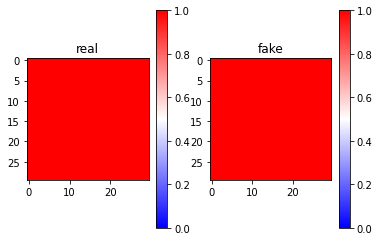

28800 28800
TP: 28800
FP: 0
FN: 28800
TN: 0
recall:    0.5
precision: 1.0
accuracy:  0.5


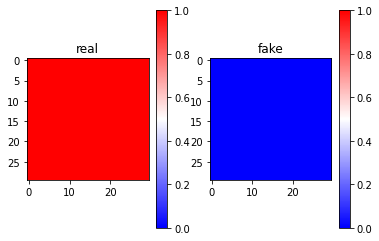

28800 28800
TP: 28800
FP: 0
FN: 0
TN: 28800
recall:    1.0
precision: 1.0
accuracy:  1.0


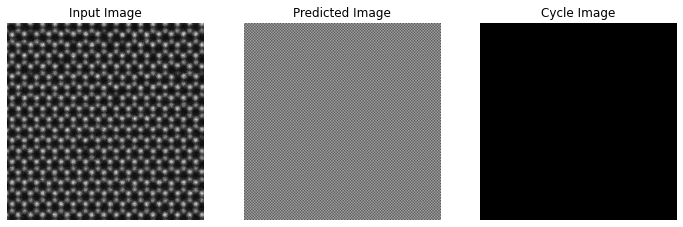

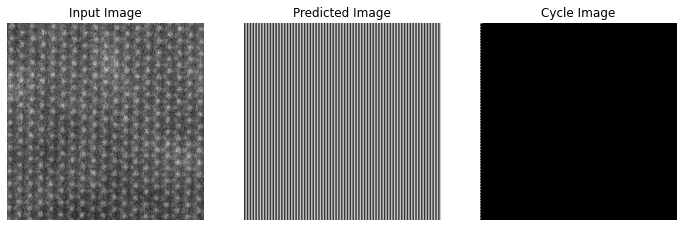

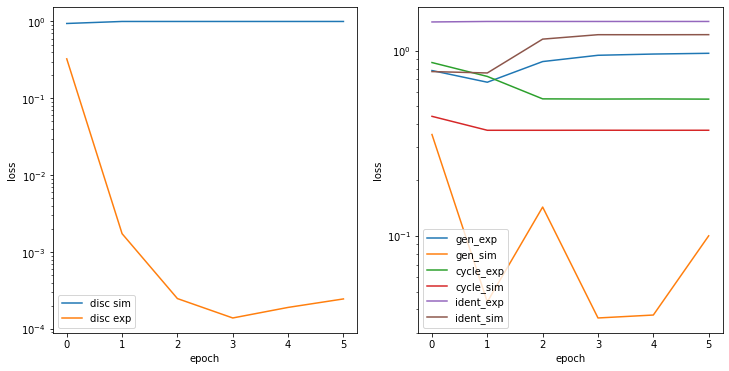

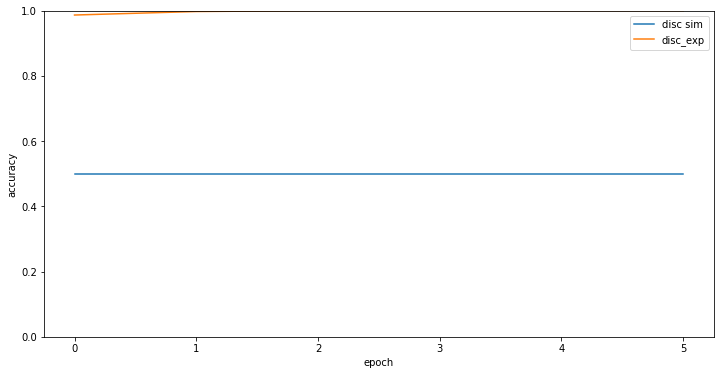

Time taken for epoch 6 is 70.65815091133118 sec

6 0.2
[0/53]: 0.04165384918451309
[1/53]: 0.04106231778860092
[2/53]: 0.040671028196811676
[3/53]: 0.040412068367004395
[4/53]: 0.04062435030937195
[5/53]: 0.04068917781114578
[6/53]: 0.04053021967411041
[7/53]: 0.043420128524303436
[8/53]: 0.04255463927984238
[9/53]: 0.041380107402801514
[10/53]: 0.041169747710227966
[11/53]: 0.040619514882564545
[12/53]: 0.042035169899463654
[13/53]: 0.04309516400098801
[14/53]: 0.04560864716768265
[15/53]: 0.04149985313415527
[16/53]: 0.04183252900838852
[17/53]: 0.042000144720077515
[18/53]: 0.04117823392152786
[19/53]: 0.042268507182598114
[20/53]: 0.04390009492635727
[21/53]: 0.042256973683834076
[22/53]: 0.04159896820783615
[23/53]: 0.040670692920684814
[24/53]: 0.040630437433719635


In [10]:
data_sim = glob('{}/*.*'.format(sim_dir))
data_exp = glob('{}/*.*'.format(exp_dir))

batch_idxs = min(min(len(data_sim), len(data_exp)), train_size) // batch_size
print("batch_idxs = ", batch_idxs)

while epoch < total_epochs:
    start = time.time()
    lr = lr0*(1 - (epoch - epoch_step)/(total_epochs-1 - epoch_step)) if epoch >= epoch_step else lr0
    print(epoch, lr)
    generator_exp_optimizer.lr.assign(lr)
    generator_sim_optimizer.lr.assign(lr)
    discriminator_sim_optimizer.lr.assign(lr)
    discriminator_exp_optimizer.lr.assign(lr)
    discriminator_sim_fft_optimizer.lr.assign(lr)
    discriminator_exp_fft_optimizer.lr.assign(lr)

    np.random.shuffle(data_sim)
    np.random.shuffle(data_exp)

    dis_losses, gen_losses = np.zeros(4), np.zeros(6)
    for idx in range(0, batch_idxs):
        batch_start =  time.time()
        sim_fn_list = data_sim[idx*batch_size:(idx + 1)*batch_size]
        exp_fn_list = data_exp[idx*batch_size:(idx + 1)*batch_size]

        real_sim = np.array([load_train_data(fn, num_channels) for fn in sim_fn_list]).astype(np.float32)
        real_exp = np.array([load_train_data(fn, num_channels) for fn in exp_fn_list]).astype(np.float32)

        dis_losses += train_discriminators(real_sim, real_exp, train=True)
        gen_losses += train_generators(real_sim, real_exp, train=True)

        print("[{}/{}]: {}".format(idx, batch_idxs, (time.time()-batch_start)/batch_size))

    clear_output(wait=True)
    cycle_exp_loss, cycle_sim_loss, gen_exp_loss, gen_sim_loss, dist_gen_exp_loss, dist_gen_sim_loss= gen_losses/batch_idxs
    disc_sim_loss, disc_exp_loss, disc_sim_loss_fft, disc_exp_loss_fft = dis_losses/batch_idxs

    # Calculate accuracy
    fake_sim = generator_sim(real_exp, training=False)
    fake_exp = generator_exp(real_sim, training=False)

    disc_sim_acc = get_discriminator_acc(discriminator_sim, real_sim, fake_sim, threshold=0.5)
    disc_exp_acc = get_discriminator_acc(discriminator_exp, real_exp, fake_exp, threshold=0.5)

    gen_exp_losses.append(gen_exp_loss)
    gen_sim_losses.append(gen_sim_loss)
    cycle_exp_losses.append(cycle_exp_loss)
    cycle_sim_losses.append(cycle_sim_loss)
    dist_gen_exp_losses.append(dist_gen_exp_loss)
    dist_gen_sim_losses.append(dist_gen_sim_loss)
    disc_sim_losses.append(disc_sim_loss)
    disc_exp_losses.append(disc_exp_loss)
    disc_sim_fft_losses.append(disc_sim_loss_fft)
    disc_exp_fft_losses.append(disc_exp_loss_fft)
    disc_sim_accs.append(disc_sim_acc)
    disc_exp_accs.append(disc_exp_acc)
    epoch += 1

    sample_sim = real_sim[0].reshape([1,fine_size,fine_size,num_channels])
    sample_exp = real_exp[0].reshape([1,fine_size,fine_size,1])
    generate_images(generator_exp, generator_sim, sample_sim)
    generate_images(generator_sim, generator_exp, sample_exp)
    generate_losses(gen_exp_losses,   gen_sim_losses,
                    cycle_exp_losses, cycle_sim_losses,
                    dist_gen_exp_losses, dist_gen_sim_losses,
                    disc_sim_losses,  disc_exp_losses,   epoch, last=last)
    generate_accuracies(disc_sim_accs, disc_exp_accs, epoch, last=last)

    if (epoch) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path))
        pickle.dump( (    gen_exp_losses,   gen_sim_losses, 
                         disc_exp_losses,  disc_sim_losses,
                      disc_exp_fft_losses,  disc_sim_fft_losses,
                        cycle_exp_losses, cycle_sim_losses,
                        dist_gen_exp_losses, dist_gen_sim_losses,
                         disc_exp_accs,    disc_sim_accs,      
                        epoch-1),
                     open( log_data_fn, "wb" ) )

    print ('Time taken for epoch {} is {} sec\n'.format(epoch, time.time()-start))

In [ ]:
discriminator_exp(real_sim)

<tf.Tensor: shape=(32, 30, 30, 1), dtype=float32, numpy=
array([[[[0.7252757 ],
         [0.7846389 ],
         [0.61985785],
         ...,
         [0.80941314],
         [1.        ],
         [1.        ]],

        [[0.6413857 ],
         [0.86949104],
         [0.80444336],
         ...,
         [0.9688797 ],
         [1.        ],
         [1.        ]],

        [[0.724055  ],
         [0.87913257],
         [0.7533442 ],
         ...,
         [0.98564804],
         [1.        ],
         [1.        ]],

        ...,

        [[0.5315296 ],
         [0.8087962 ],
         [0.89140713],
         ...,
         [0.76782936],
         [1.        ],
         [1.        ]],

        [[0.46139145],
         [0.69918156],
         [0.81057453],
         ...,
         [0.87293506],
         [1.        ],
         [1.        ]],

        [[0.34847197],
         [0.54162276],
         [0.6219453 ],
         ...,
         [0.65449333],
         [1.        ],
         [1.        ]]],


   

In [ ]:
import matplotlib.pyplot as plt
i = 2
fn_list = [x for x in os.listdir(sim_dir) if ".tif" in x]
fn = fn_list[i]
print(fn)
img = load_train_data(os.path.join(sim_dir,fn))
for i in range(num_channels):
    plt.figure()
    plt.imshow(img[:,:,i])
plt.show()

sim_images_stack0000_002.tiff


TypeError: load_train_data() missing 1 required positional argument: 'num_channels'

In [ ]:
np.log(np.max(get_logf2(real_exp)))

In [ ]:
np.finfo(np.float32)